**Importing Libs**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
import pickle
%matplotlib inline

***VISUALISING THE DATASET***

In [45]:
json_path = './dataset.json'
df = pd.read_json(json_path)
print(df.head(),'\n')
print(df.dtypes)

                                      externalStatus    internalStatus
0                                           PORT OUT          Port Out
1                                        TERMINAL IN  Inbound Terminal
2                                            PORT IN           Port In
3  Vessel departure from first POL (Vessel name :...         Departure
4  Vessel arrival at final POD (Vessel name : TIA...           Arrival 

externalStatus    object
internalStatus    object
dtype: object


In [46]:
df['externalStatus'] = df['externalStatus'].astype(str)
df['internalStatus'] = df['internalStatus'].astype(str)

In [47]:
print(df.isnull().sum())

externalStatus    0
internalStatus    0
dtype: int64


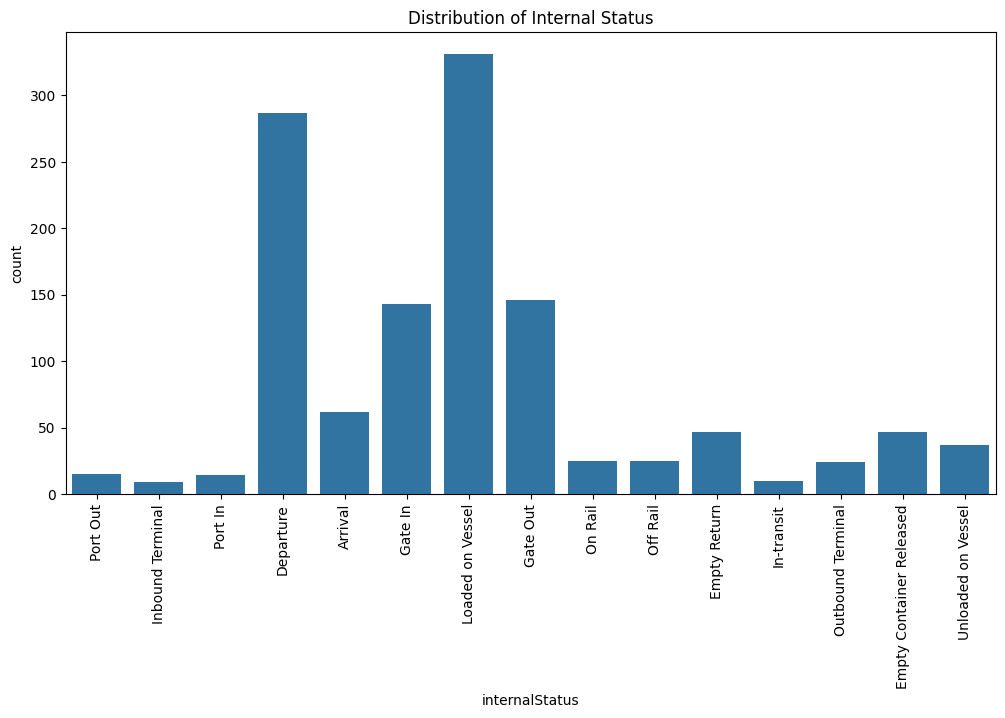

In [48]:
# plt.figure(figsize=(12, 6))
# sns.countplot(x='externalStatus', data=df)
# plt.xticks(rotation=90)
# plt.title('Distribution of External Status')
# plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(x='internalStatus', data=df)
plt.xticks(rotation=90)
plt.title('Distribution of Internal Status')
plt.show()

***PREPROCESSING AND TOKENIZING THE LABELS***

In [49]:
le = LabelEncoder()
df['internalStatus'] = le.fit_transform(df['internalStatus'])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df['externalStatus'], df['internalStatus'], test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(X_train.size, X_test.size, X_val.size)

989 123 110


In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences
max_length = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_train_pad = np.expand_dims(X_train_pad, axis=-1)
X_test_pad = np.expand_dims(X_test_pad, axis=-1)
X_val_pad = np.expand_dims(X_val_pad, axis=-1)

***BUILDING THE BiLSTM MODEL***

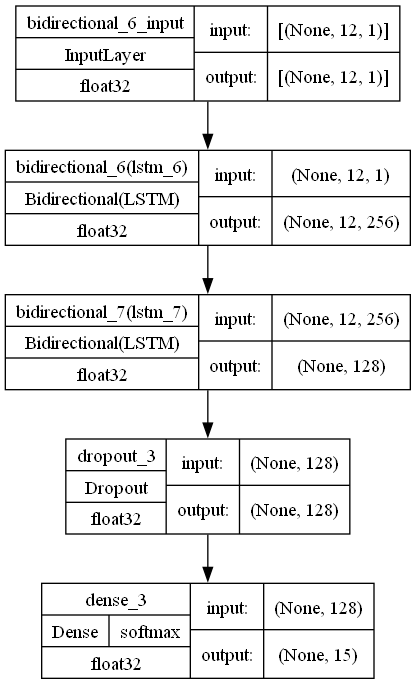

In [84]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(max_length,1)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
tensorboard_callback = TensorBoard("logs")
checkpoint = ModelCheckpoint("bestWeights.keras", monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
early = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')
lrr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.4, min_lr=0.00001, mode='auto')

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model,show_dtype=True,show_layer_activations=True,show_shapes=True)

***TRAINING AND EVALUATING THE MODEL***

In [53]:
hist = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=100, batch_size=32, callbacks=[checkpoint,early,lrr,tensorboard_callback])

Epoch 1/100
29/31 [===========================>..] - ETA: 0s - loss: 2.0813 - accuracy: 0.3772
Epoch 1: accuracy improved from -inf to 0.38524, saving model to bestWeights.keras
31/31 [==============================] - 6s 52ms/step - loss: 2.0538 - accuracy: 0.3852 - val_loss: 1.6211 - val_accuracy: 0.5182 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 1.4684 - accuracy: 0.4954
Epoch 2: accuracy improved from 0.38524 to 0.49545, saving model to bestWeights.keras
31/31 [==============================] - 0s 14ms/step - loss: 1.4684 - accuracy: 0.4954 - val_loss: 1.1747 - val_accuracy: 0.5727 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.6178
Epoch 3: accuracy improved from 0.49545 to 0.61780, saving model to bestWeights.keras
31/31 [==============================] - 0s 14ms/step - loss: 1.0815 - accuracy: 0.6178 - val_loss: 0.7469 - val_accuracy: 0.8273 - lr: 0.0010
Epoch 4/100
30/31 [============

In [82]:
np.save('label_encoder_classes.npy', le.classes_)
np.save('max_length.npy', max_length)
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [55]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy*100:.2f}")

4/4 [==============================] - 0s 9ms/step - loss: 0.0379 - accuracy: 0.9837
Test Loss: 0.04
Test Accuracy: 98.37


In [ ]:
predictions = model.predict(X_test_pad, steps=len(X_test_pad), verbose=0)
predclasses = []
for encoded_labels in np.round(predictions):
    predclasses.append(np.argmax(encoded_labels))

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predclasses))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.93      1.00      0.96        25
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        16
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.96      0.98        23
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         2

    accuracy                           0.98       123
   macro avg       1.00      0.99      0.99       123
weighted avg       0.98   

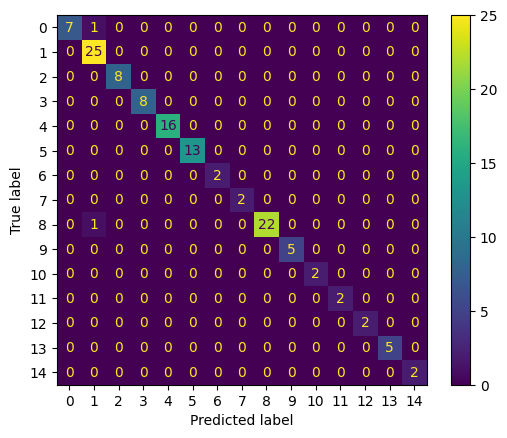

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, predclasses)
plt.show()

***Further training is not done as Model is good enough with ~ 98 accuracy 100 precision and 99 recall score on test dataset***